# InSAR Validation using GPS

## Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from pyproj import Proj, transform
import matplotlib.cm as cm
from scipy.interpolate import griddata
import datetime
from scipy import stats
from sympy import pretty_print as pp, latex

## InSAR Data Validation

### Reading InSAR results

In [20]:
# Reading SARPROZ csv output
sar_csv = np.loadtxt("newest_star.csv", delimiter=",", skiprows=1, \
                     dtype=str)
#printing the entries in the csv file
print sar_csv[0]

['ID' 'LAT' 'LON' 'HEIGHT' 'HEIGHT WRT DEM' 'SIGMA HEIGHT' 'VEL'
 'SIGMA VEL' 'SEASONAL' 'CUMUL.DISP.' 'COHER' 'SVET' 'LVET' 'IN' 'FIN'
 'STDEV' '20140418' '20140512' '20140605' '20140629' '20140723' '20140816'
 '20141003' '20141027' '20141120' '20141214' '20150107' '20150131'
 '20150224' '20150320' '20150413' '20150531' '20150624' '20150718'
 '20150811' '20150904' '20150928' '20151209' '20160102' '20160126'
 '20160219' '20160314' '20160407' '20160501' '20160525' '20160618'
 '20160712' '20160805' '20160829' '20160922' '20161016' '20161109'
 '20161203' '20161227']


### InSAR Acquisition Time (Julian date)

In [5]:
#template of dates to be converted to Julian dates (YYYYmmdd)
s = '%Y%m%d'
#List to include Julian dates
insar_t=[]
# For loop to convert each date to julian date starting from 20140418
for i in sar_csv[0][np.where(sar_csv[0]=='20140418')[0][0]:]:
    date = datetime.datetime.strptime(i, s)
    date = ((date.timetuple().tm_year+(date.timetuple().tm_yday/365.)))
    insar_t.append(date)
print insar_t

[2014.295890410959, 2014.3616438356164, 2014.427397260274, 2014.4931506849316, 2014.558904109589, 2014.6246575342466, 2014.7561643835616, 2014.8219178082193, 2014.8876712328768, 2014.9534246575342, 2015.0191780821917, 2015.0849315068492, 2015.150684931507, 2015.2164383561644, 2015.282191780822, 2015.4136986301369, 2015.4794520547946, 2015.545205479452, 2015.6109589041096, 2015.676712328767, 2015.7424657534248, 2015.9397260273972, 2016.0054794520547, 2016.0712328767124, 2016.13698630137, 2016.2027397260274, 2016.268493150685, 2016.3342465753424, 2016.4, 2016.4657534246576, 2016.531506849315, 2016.5972602739726, 2016.66301369863, 2016.7287671232878, 2016.7945205479452, 2016.8602739726027, 2016.9260273972602, 2016.9917808219177]


### Histogram of PS standard deviation

(array([  4.60000000e+01,   5.13000000e+02,   2.54000000e+03,
          7.46000000e+03,   1.29130000e+04,   1.76560000e+04,
          1.93540000e+04,   1.80000000e+04,   1.22070000e+04,
          8.21500000e+03,   6.11400000e+03,   4.55200000e+03,
          4.37200000e+03,   4.42900000e+03,   4.95100000e+03,
          4.03700000e+03,   3.04400000e+03,   1.80000000e+03,
          1.06200000e+03,   6.01000000e+02,   3.06000000e+02,
          1.77000000e+02,   9.50000000e+01,   3.40000000e+01,
          1.70000000e+01,   1.20000000e+01,   4.00000000e+00,
          6.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([ 0.55   ,  0.68275,  0.8155 ,  0.94825,  1.081  ,  1.21375,
         1.3465 ,  1.47925,  1.612  ,  1.74475,  1.8775 ,  2.01025,
         2.143  ,  2.27575,  2

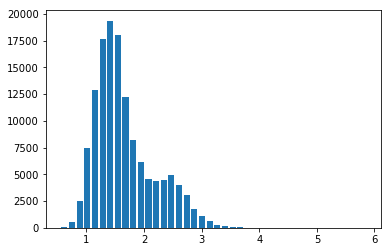

In [6]:
# Histogram of PS standard deviation
sar_csv_float = np.loadtxt("newest_star_5smart.csv", delimiter=",", \
                           skiprows=2)
plt.hist(sar_csv_float[:, np.where(sar_csv[0]=='STDEV')[0][0]], bins=40,\
         rwidth=0.8)

### Filtering PS points and projecting them into PSD93

In [6]:
# list to include filtered Persistent Scatterers (PS)
data = {'Easting':[],'Northing':[],'ps_timeseries':[]}

lat=[]
lon=[]
for i in xrange(1,len(sar_csv)):
    # filter out PS with standard deviation of more than 1.7
    if float(sar_csv[i][np.where(sar_csv[0]=='STDEV')[0][0]])<1.7:
        # column number of the start of InSAR deformation time series
        c = np.where(sar_csv[0]=='20140418')[0][0]
        
# obtain lat,lon and deformation measurement for each 'good' PS
        lat.append(float(sar_csv[i][1]))
        lon.append(float(sar_csv[i][2]))
        data['ps_timeseries'].append(sar_csv[i][c:])   
    else:
        pass

# projecting lat,lon in PSD93
inProj = Proj(init='epsg:4326') #input is in WGS84
outProj = Proj(init='epsg:3440') #output in PSD93
x, y = transform(inProj, outProj, lon, lat)
# adding new transformed coordinates to the dictionary
data['Easting'].append(x)
data['Northing'].append(y)

### Importing GPS data and projecting them into PSD93

In [7]:
#loading station coordinates file
coord =  np.loadtxt('Coord.csv',usecols=(0,1,2),unpack=True,dtype=str)
#Dictionary to save station coordinates and displacement
GPS={'Station':[],'Easting':[],'Northing':[],'Disp':[],'Time':[]}
#lists to save decimal degree angles
decimal_lat=[]
decimal_lon=[]
# loop to convert coordinates from DD'MM'SS' to decimal degrees
for i in xrange(1,len(coord[0])):
    lat = coord[1][i]
    lon = coord[2][i]
    # \xc2\xb0, \xe2\x80\x99 and \xe2\x80\x9d are the symbols for degrees, minutes and seconds.
    lat_deg= lat.split('\xc2\xb0')
    lat_min =lat_deg[1].split('\xe2\x80\x99')
    lat_sec = lat_min[1].split('\xe2\x80\x9d')
    
    lon_deg= lon.split('\xc2\xb0')
    lon_min =lon_deg[1].split('\xe2\x80\x99')
    lon_sec = lon_min[1].split('\xe2\x80\x9d')
    
    lat_decimal= float(lat_deg[0])+(float(lat_min[0])/60)+\
    (float(lat_sec[0])/3600)
    lon_decimal= float(lon_deg[0])+(float(lon_min[0])/60)+\
    (float(lon_sec[0])/3600)
    
    GPS['Station'].append(coord[0][i])
    decimal_lat.append(lat_decimal)
    decimal_lon.append(lon_decimal)
#Projecting the coordinates in PSD93
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3440')
gps_x, gps_y = transform(inProj, outProj, decimal_lon, decimal_lat)
GPS['Easting'].append(gps_x)
GPS['Northing'].append(gps_y)


In [8]:
# Loading GPS campaign files
dc17 = np.loadtxt("DC17.csv", skiprows=1, usecols=(0,5), dtype=str)
dc18 = np.loadtxt("DC18.csv", skiprows=1, usecols=(0,5), dtype=str)
dc19 = np.loadtxt("DC19.csv", skiprows=1, usecols=(0,5), dtype=str)
dc20 = np.loadtxt("DC20.csv", skiprows=1, usecols=(0,5), dtype=str)
dc21 = np.loadtxt("DC21.csv", skiprows=1, usecols=(0,5), dtype=str)
dc22 = np.loadtxt("DC22.csv", skiprows=1, usecols=(0,5), dtype=str)
dc23 = np.loadtxt("DC23.csv", skiprows=1, usecols=(0,5), dtype=str)
dc24 = np.loadtxt("DC24.csv", skiprows=1, usecols=(0,5), dtype=str)
# corresponding GPS campaigns time
dc17_t= ['2014.01.24','2014.02.22']
dc18_t= ['2014.04.24','2014.05.13']
dc19_t= ['2014.07.24','2014.08.08']
dc20_t= ['2014.11.01','2014.11.19']
dc21_t= ['2015.01.25','2015.02.18']
dc22_t= ['2015.04.21','2015.05.11']
dc23_t= ['2015.07.27','2015.08.09']
dc24_t= ['2015.11.26','2015.12.09']
#List of GPS campaign time
Campaign = [dc17_t, dc18_t, dc19_t,dc20_t,dc21_t,dc22_t,dc23_t,dc24_t]

# List of GPS data
GPS_data = [dc17, dc18, dc19, dc20, dc21, dc22, dc23, dc24]

# Computing average day for each campaign and converting it to Julian date.
s = '%Y.%m.%d'
cam_t=[]
for i in Campaign:
    start_date = datetime.datetime.strptime(i[0], s)
    end_date = datetime.datetime.strptime(i[1], s)
    mid_date = ((start_date.timetuple().tm_year+\
    (start_date.timetuple().tm_yday/365.))+(end_date.timetuple().tm_year+\
                            (end_date.timetuple().tm_yday/365.)))/2
    cam_t.append(mid_date)


# Loop to find heights for each station in every campaign
for i in GPS['Station']:
    # lists to include all heights and time for each station
    h =[]
    t=[]
    # for loop to get heights from gps data
    for n,m in enumerate(GPS_data):
# finding the index in each GPS campaign of the station in the first loop
        x,y=np.where(m==i)
# if the index is found (station height was measured in that campaign), 
#convert height to mm, add the height and time to the lists above
        try:
            hgt1 = float(m[x,1][0])*1000 
            h.append(hgt1)
            t.append(cam_t[n])
        except:
            pass
# interpolate height that match the first insar acuisition time
    int_hgt = ((2014.29589041 - t[0])/(t[1]-t[0]))*(h[1]-h[0])+h[0]
# for loop to get displacements (instead of heights) starting.. 
#from the first sar acuisition
    height=[]
    time = []
    for ii in xrange(0,len(h)):
# displacemet starts from 0 at 2014.29589041 (first sar)
        if ii ==0:
            height.append(0) 
            time.append(2014.29589041)
# the interpolated height at 2014.29589041 is subtracted from..
# subsequent heights to obtain displacements
        else:
            hgt= h[ii]-int_hgt
            height.append(hgt)
            time.append(t[ii])
    GPS['Disp'].append(np.array(height))
    GPS['Time'].append(np.array(time))

### Finding PS targets closest to each GPS station

In [9]:
# dictionary to save nearest PS points to each station, distances,
#and interpolated PS
gps_ps={'station':[], 'PS':[] , 'distance':[],'IDW':[]}
#loop to gp through all stations
for i in xrange(0,len(GPS['Station'])):
# two lists to include index of PS that are close to GPS station
#with distance 
    dis_list=[]
    ps_list=[]
#loop to go through all ps points
    for ii in xrange(0,len(data['Easting'][0])): 
# calculate the distance between each GPS station and all PSs
        distance = np.sqrt(((float(GPS['Northing'][0][i])-\
data['Northing'][0][ii])**2)+((float(GPS['Easting'][0][i])-\
                               data['Easting'][0][ii])**2))
# saving the ps index and the actual distance if the PS is within
# 100 m of the GPS station
        if distance<100:
            dis_list.append(distance)
            ps_list.append(ii)
        
# if any ps are found, save station name, ps index and distances        
    if ps_list:
        gps_ps['station'].append(GPS['Station'][i])
        gps_ps['PS'].append(ps_list)
        gps_ps['distance'].append(dis_list)
# loop to include idw displacement for each station
        idw_list=[]
        for iii in xrange(0,22):
# lists to include weight multiplied by observation (zw) and weights (w)
            zw_list=[]
            w_list=[]
# loop to calculate interpolated PS using the PSs and distances found
            for d in xrange(0,len(gps_ps['distance'][-1])):
                zw=(1./gps_ps['distance'][-1][d])*float(data['ps_timeseries']\
                            [ps_list[d]][iii])* 1/np.cos(np.radians(32.4745))
                w=1./gps_ps['distance'][-1][d]
                zw_list.append(zw)
                w_list.append(w) 
            idw_list.append(sum(zw_list)/sum(w_list))
# saving the interpolated PS time series
        gps_ps['IDW'].append(idw_list)
    

### Plotting GPS and InSAR time series

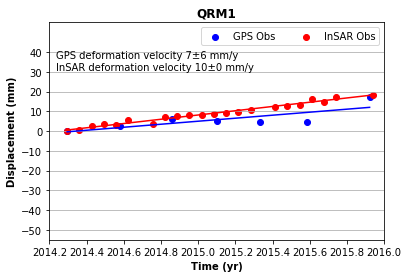

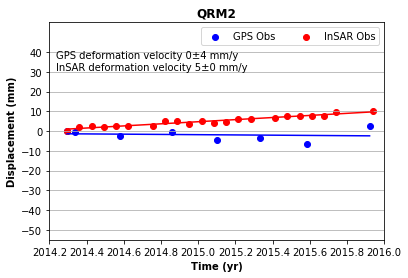

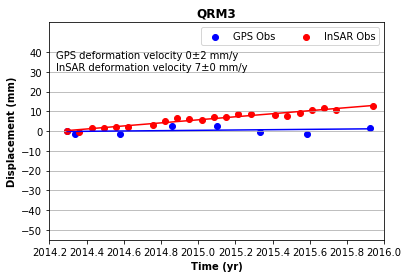

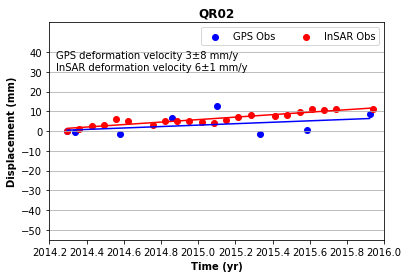

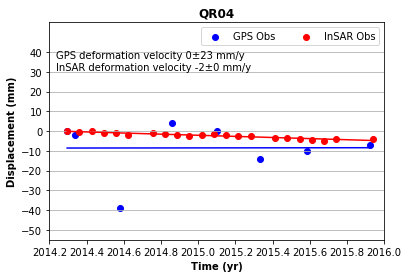

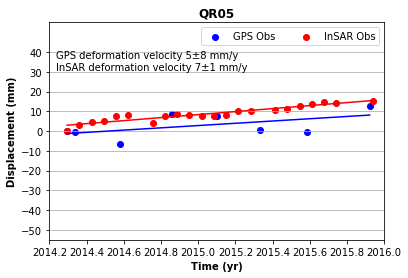

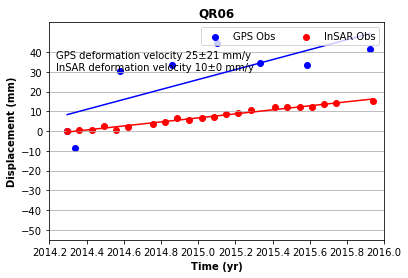

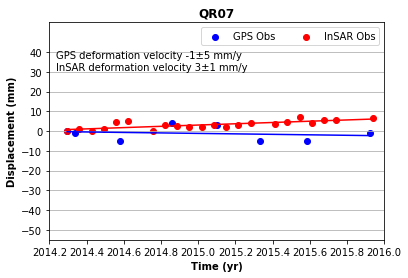

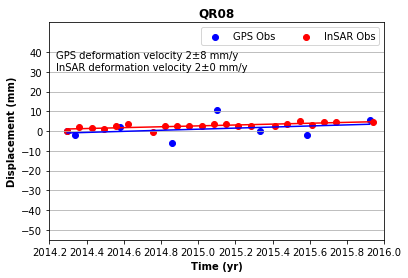

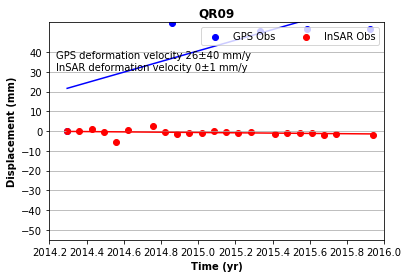

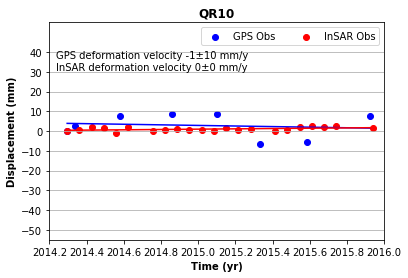

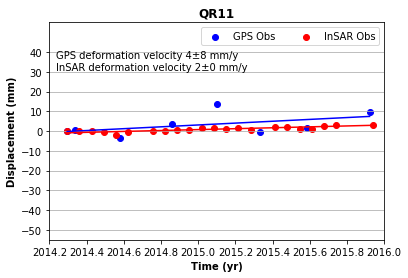

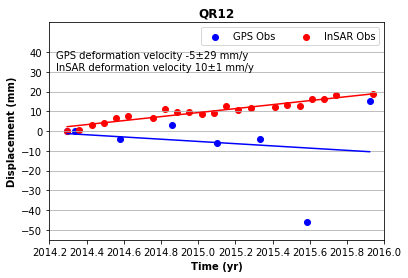

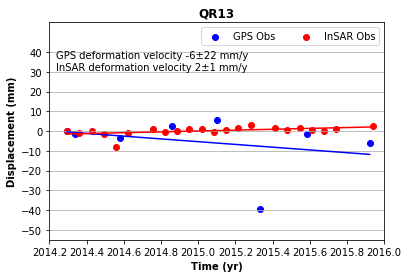

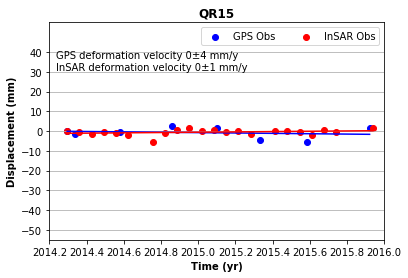

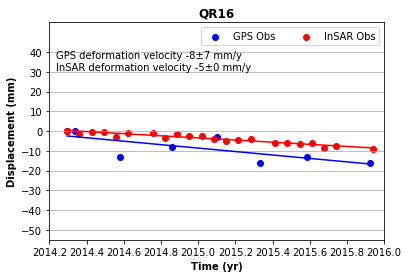

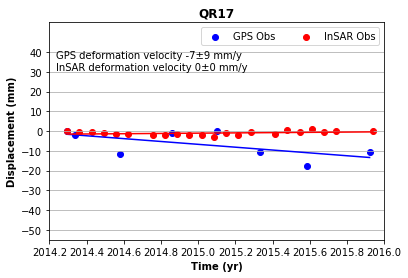

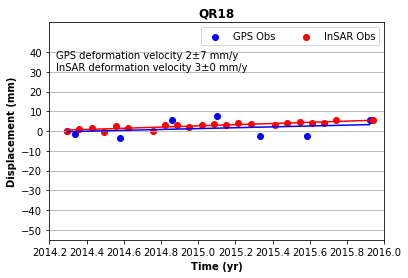

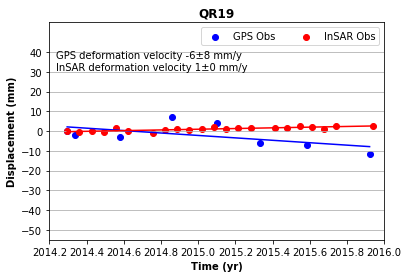

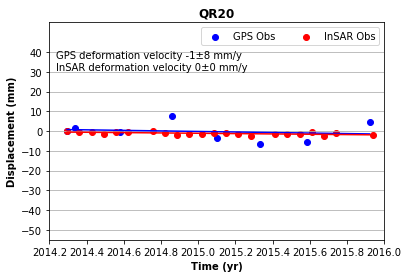

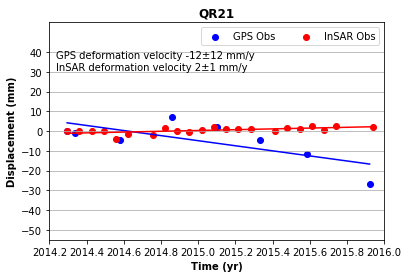

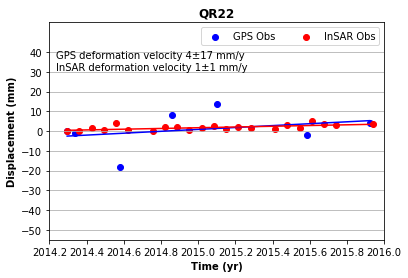

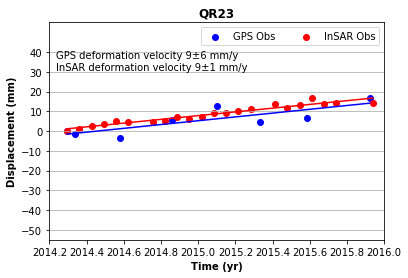

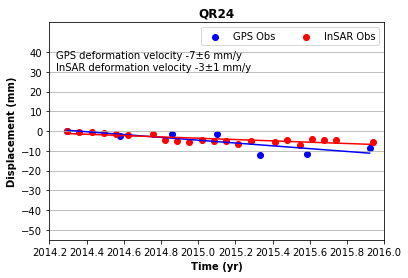

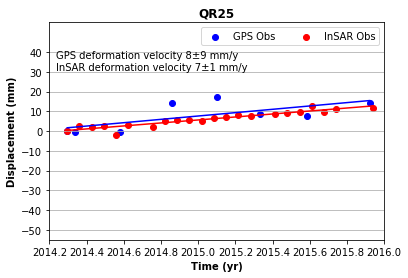

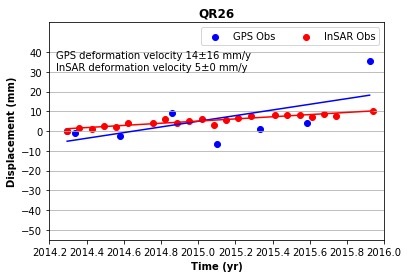

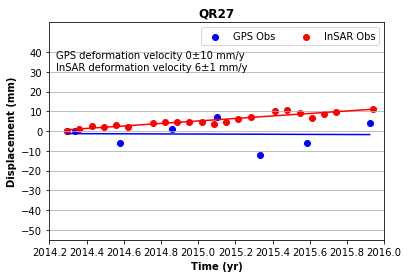

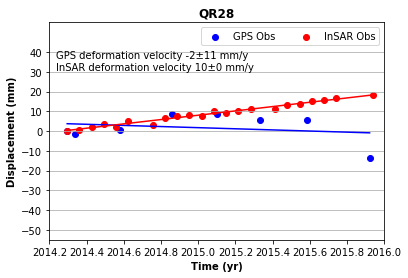

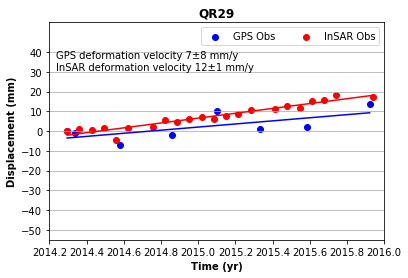

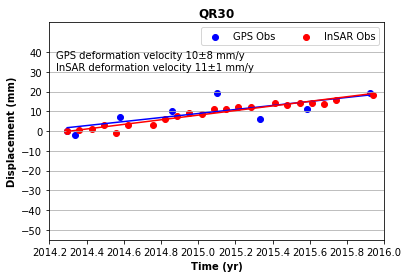

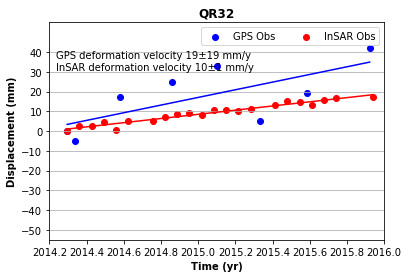

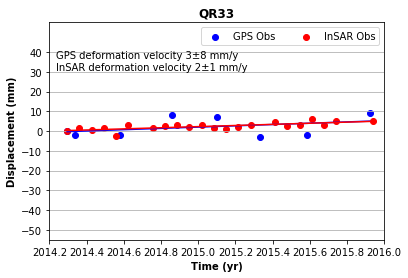

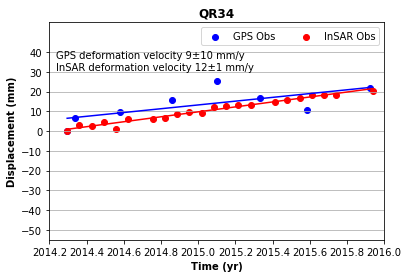

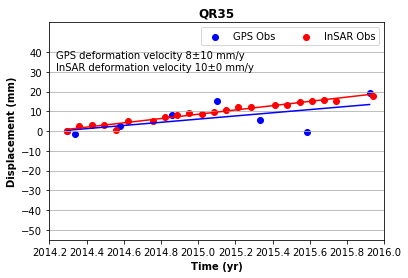

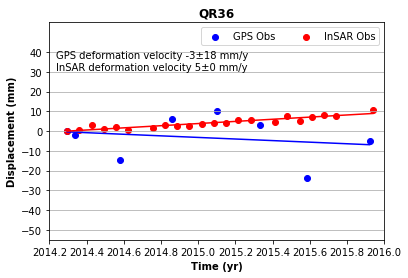

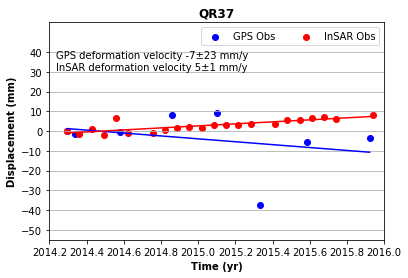

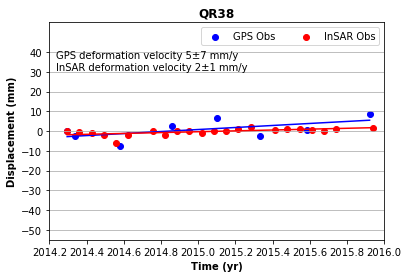

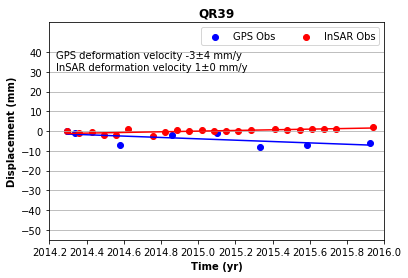

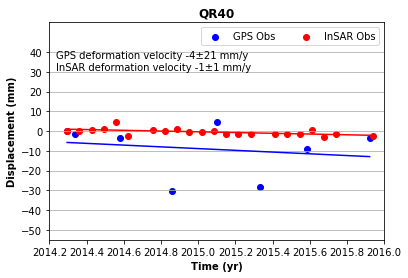

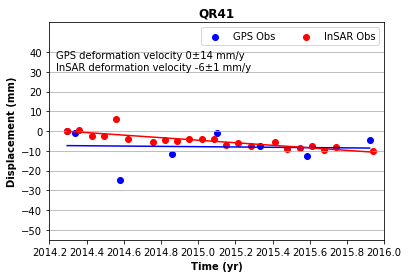

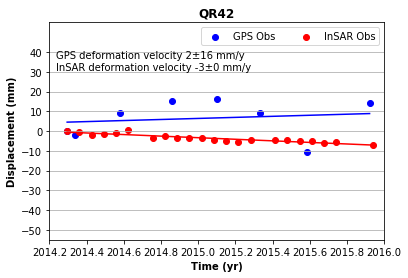

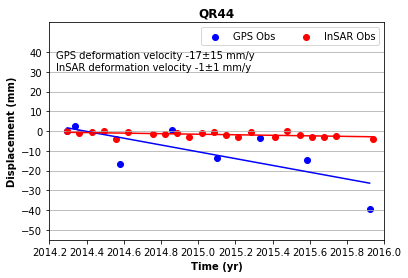

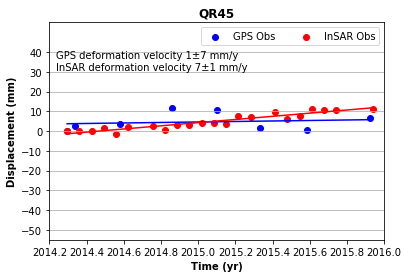

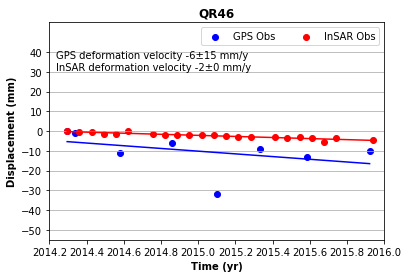

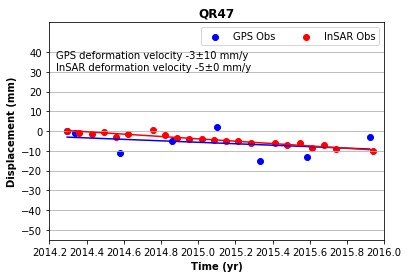

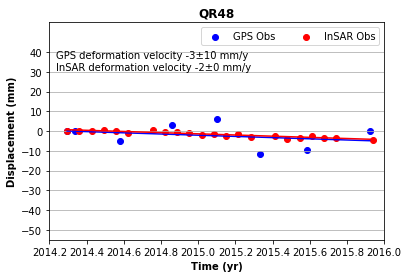

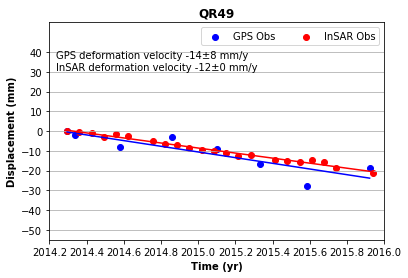

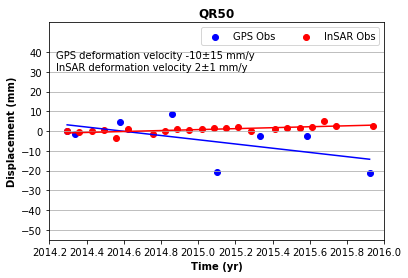

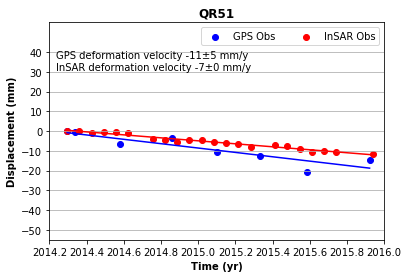

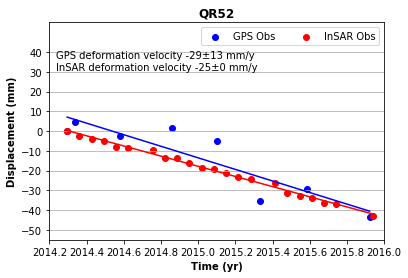

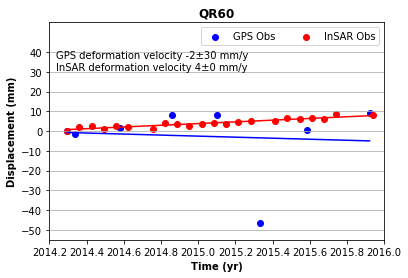

In [23]:
# lists to include obtained slopes
slope_gps =[]
slope_insar =[]
# loop to plot time series for each station
for i in xrange(0,len(gps_ps['station'])):
    plt.figure()
    plt.title(gps_ps['station'][i],fontweight='bold')
    ax = plt.gca()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
# finding the index of this gps station in the GPS dictionary
    c = np.where(np.array(GPS['Station'])==gps_ps['station'][i])[0][0]
# plot GPS time series
    gps_plot = plt.scatter(GPS['Time'][c],GPS['Disp'][c],marker=\
                           'o', c='b',)
# linear regression analysis of GPS time series
    slope_GPS, intercept, r_value_gps, p_value_gps, std_err_gps = \
    stats.linregress(GPS['Time'][c],GPS['Disp'][c])
    plt.plot(GPS['Time'][c], np.poly1d(np.polyfit(GPS['Time'][c],\
                            GPS['Disp'][c], 1))(GPS['Time'][c]),'-b')
# t-test to obtain confidence interval for GPS 
    ttest_gps = stats.t.ppf(1-0.025, len(GPS['Time'][c])-2)
    
    ax=plt.axes()
    ax.yaxis.grid()   
    plt.xlabel('Time (yr)',fontweight='bold')
    plt.ylabel('Displacement (mm)',fontweight='bold')

# plot InSAR time series
    insar_plot=plt.scatter(insar_t[:22],gps_ps['IDW'][i],c='r')
    plt.plot(insar_t[:22], np.poly1d(np.polyfit(insar_t[:22],\
                            gps_ps['IDW'][i], 1))(insar_t[:22]),'-r')   
    
# linear regression analysis of InSAR time series
    slope_InSAR, intercept, r_value_sar, p_value, std_err_sar =\
    stats.linregress(insar_t[:22],gps_ps['IDW'][i])
# t-test to obtain confidence interval for InSAR     
    ttest_sar = stats.t.ppf(1-0.025, len(insar_t[:22])-2)
    
    plt.annotate('GPS deformation velocity %d±%d mm/y \nInSAR deformation velocity %d±%d mm/y'\
%(slope_GPS,ttest_gps*std_err_gps,slope_InSAR,ttest_sar*std_err_sar)\
                 , xy=(0.02, 0.78), xycoords='axes fraction')
    plt.legend((gps_plot,insar_plot),('GPS Obs', 'InSAR Obs')\
, scatterpoints=1, loc='upper right',ncol=3,fontsize=10)
    
    plt.ylim(-55,55)
    ax.yaxis.set_ticks(np.arange(-50, 50, 10))
    plt.xlim(2014.2,2016)
    plt.savefig('images/w%s.png'%gps_ps['station'][i])
    
    slope_gps.append(slope_GPS)
    slope_insar.append(slope_InSAR)

### GPS vs InSAR velocities

RMSE = 7.92715335749
mean 5.84537707173
Maximum Difference 27.6827697166
Minimum Difference 0.0568524740447


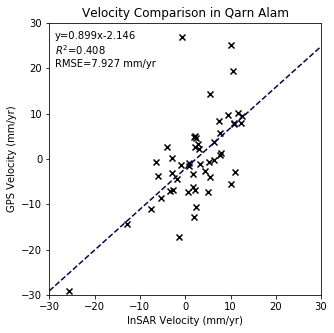

In [11]:
plt.figure(figsize=(5,5))
# plot insar vs gps alng with linear regression
plt.scatter(slope_insar,slope_gps,marker='x',color='k')
plt.xlabel('InSAR Velocity (mm/yr)')
plt.ylabel('GPS Velocity (mm/yr)')
plt.title('Velocity Comparison in Qarn Alam')
plt.tick_params()
slope, intercept, r_value, p_value, std_err = stats.linregress\
    (slope_insar,slope_gps)
plt.plot([-30, 30], [slope*-30+intercept, slope*30+intercept],\
         '--',color='#000066')   

# loop to calculate velocity differences and rmse
diff_slope=[]
error=[]
for i in xrange(0,len(slope_gps)):
    dif=abs(slope_gps[i]-slope_insar[i])
    diff_slope.append(dif)
    error_squared=abs(slope_gps[i]-slope_insar[i])**2
    error.append(error_squared)
rmse = np.sqrt(sum(error)/len(error))
# adding annotation (linear regression equation, r-squared and rmse)
plt.annotate('y=%.3fx%.3f\n$R^{2}$=%.3f\nRMSE=%.3f mm/yr'\
%(slope,intercept,r_value**2,rmse), xy=(0.02, 0.84),xycoords=\
             'axes fraction')  
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('insar_gps3.png')
print 'RMSE =',rmse
print 'mean',np.mean(diff_slope)
print 'Maximum Difference',max(diff_slope)
print 'Minimum Difference',min(diff_slope)


### histogram of velocity differences

16.034253787028824

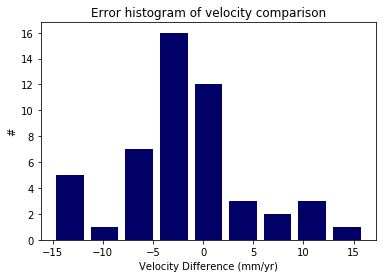

In [333]:
# error histogram for velocity differences
diff_slope=[]
for i in xrange(0,len(slope_gps)):
    dif=(slope_gps[i]-slope_insar[i])
    diff_slope.append(dif)
plt.hist(diff_slope, bins=9,linestyle=('dashed'),color=('#000066')\
         ,rwidth=0.8)
plt.xlabel('Velocity Difference (mm/yr)')
plt.ylabel('#')
plt.title('Error histogram of velocity comparison')
plt.savefig('insar_gps_hist.png')
print max(diff_slope)

### GPS vs InSAR velocities after removing outliers

RMSE: 3.50019482601
Mean: 2.96608608375
Maximum DIfference: 6.73747267635
Minimum Difference: 0.0568524740447


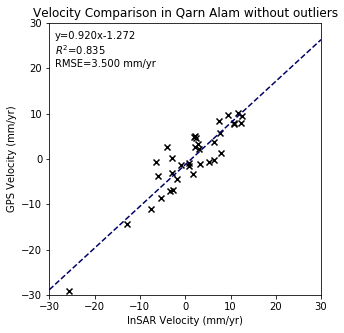

In [19]:
# lists to include slopes of remaining stations' velocities 
new_gps=[]
new_insar=[]

# loop to find stations that have velicity difference of less than
# two times RMSE. And then calculate remaining velocity diff and rmse
diff_slope=[]
error=[]
for i in xrange(0,len(slope_gps)):
    dif = abs(slope_gps[i]-(slope_insar[i]))
    if dif < (3.3687986889*2):
        diff_slope.append(dif)
        new_gps.append(slope_gps[i])
        new_insar.append(slope_insar[i])
        error_squared=abs(slope_gps[i]-slope_insar[i])**2
        error.append(error_squared)
rmse = np.sqrt(sum(error)/len(error))
 
#plotting velocities of remaining stations
plt.figure(figsize=(5,5))
plt.scatter(new_insar,new_gps,marker='x',color='k')
plt.xlabel('InSAR Velocity (mm/yr)')
plt.ylabel('GPS Velocity (mm/yr)')
plt.title('Velocity Comparison in Qarn Alam without outliers')
plt.tick_params()
# linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress\
    (new_insar,new_gps)
plt.plot([-30, 30], [slope*-30+intercept, slope*30+intercept], \
         '--',color='#000066')   
# annotation (linear regression equation, r-square and rmse)
plt.annotate('y=%.3fx%.3f\n$R^{2}$=%.3f\nRMSE=%.3f mm/yr'\
%(slope,intercept,r_value**2,rmse), xy=(0.02, 0.84), xycoords=\
             'axes fraction')  
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('insar_gps_no_outliers.png')
print 'RMSE:',rmse
print 'Mean:',np.mean(diff_slope)
print 'Maximum DIfference:',max(diff_slope)
print 'Minimum Difference:',min(diff_slope)


### histogram of velocity differences after removing outliers

5.80577858992


37

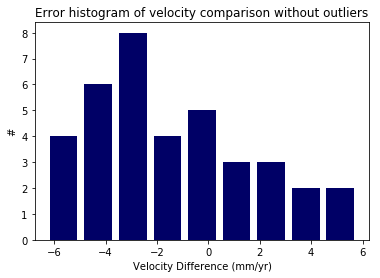

In [332]:
diff_slope=[]
for i in xrange(0,len(new_gps)):        
        dif=new_gps[i]-new_insar[i]
        diff_slope.append(dif)
plt.hist(diff_slope, bins=9,linestyle=('dashed'),color=('#000066')\
         ,rwidth=0.8)
plt.xlabel('Velocity Difference (mm/yr)')
plt.ylabel('#')
plt.title('Error histogram of velocity comparison without outliers')
plt.savefig('insar_gps_hist_no_outliers.png')